In [3]:
from typing import overload
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from tqdm.auto import tqdm
from dataprep.dataset_binance import BinanceCoinDataset
import torchvision.transforms as transforms
import pandas as pd



import numpy as np
from ml.models.BSM import BSM4
import neptune.new as neptune
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns

def stable_sigmoid(x):
    sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return sig
    
C = [
    "DOGEUSDT",
    "AVAXUSDT",
    "SOLUSDT",
    "SHIBUSDT",
    "EURUSDT",
    "GBPUSDT",
    "ETCETH",
    "ETCBTC",
    "MKRUSDT",
    "MKRBTC",
    "IOTAUSDT",
    "ADAUSDT",
    "XLMUSDT",
    "TRXUSDT",
    "XMRUSDT",
    "EOSUSDT",
    "DOGEGBP",
    "BTCEUR",
    "BTCGBP",
    "BTCUSDT",
]

In [4]:
device = torch.device('cuda')     
val_set = BinanceCoinDataset(test=(True, 0.98), window_size=512, currencies=C)

t


In [5]:
n_features = val_set.data.shape[1]
net = BSM4(n_features=n_features, n_outputs=len(val_set.currencies))

net.load_state_dict(torch.load('ml/models/BSM4.pth'))
net.cuda(device)
net.eval()

testloader = torch.utils.data.DataLoader(val_set, batch_size=512,
                                          shuffle=False, num_workers=1)

In [6]:
criterion = nn.L1Loss()
y_test = []
y_hat_test  = []
losses_test  = []
losses_test_lr = []

net.eval()

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):

        inputs, labels  = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        outputs = (labels!=-1).detach()*outputs
        labels = (labels!=-1).detach()*labels
        loss = criterion(outputs, labels)

        y_test.append(labels.cpu().detach())
        y_hat_test.append(outputs.cpu().detach())
        losses_test.append(loss.cpu())

        

0it [00:00, ?it/s]

In [7]:
y_test = np.vstack(y_test)
y_hat_test = np.vstack(y_hat_test)
losses = np.vstack(losses_test)

In [21]:
# Here I just write down manually what seems to be a good BUY and SELL threshold for each pair

In [229]:
# -1 means I don't want to play this market

C_thresholds = [
    {"pair":"DOGEUSDT","buy_thr":0.00085,"sell_thr":-1},
    {"pair":"AVAXUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"SOLUSDT","buy_thr":0.00038,"sell_thr":-0.0008},
    {"pair":"SHIBUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"EURUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"GBPUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"ETCETH","buy_thr":1,"sell_thr":-1},
    {"pair":"ETCBTC","buy_thr":1,"sell_thr":-1},
    {"pair":"MKRUSDT","buy_thr":-0.00015,"sell_thr":-1},
    {"pair":"MKRBTC","buy_thr":1,"sell_thr":-1},
    {"pair":"IOTAUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"ADAUSDT","buy_thr":0.0003,"sell_thr":-0.0003},
    {"pair":"XLMUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"TRXUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"XMRUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"EOSUSDT","buy_thr":1,"sell_thr":-1},
    {"pair":"DOGEGBP","buy_thr":1,"sell_thr":-1},
    {"pair":"BTCEUR","buy_thr":-0.00035,"sell_thr":-1},
    {"pair":"BTCGBP","buy_thr":1,"sell_thr":-1},
    {"pair":"BTCUSDT","buy_thr":1,"sell_thr":-1}
]

In [231]:
pd.DataFrame(C_thresholds).to_pickle('C_thresholds.pkl')

In [6]:
c = 0
print(C[c])
print(y_hat_test[:,c].sum(), y_test[:,c].sum() )
min_n = np.quantile(y_hat_test[:,c],0.0001) 
max_n = np.quantile(y_hat_test[:,c],0.9999)
results = []
for thr in np.arange(min_n, max_n, (max_n-min_n)/2000):
    results.append({'thr':thr, 'sum':(y_test[y_hat_test[:,c]>thr, c]-0.001).sum(),'avg':(y_test[y_hat_test[:,c]>thr, c]-0.001).mean()})

DOGEUSDT
11.012492 1.655649


In [7]:
results = pd.DataFrame(results)
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.set_style("ticks",{'axes.grid' : True})

<AxesSubplot:xlabel='thr', ylabel='sum'>

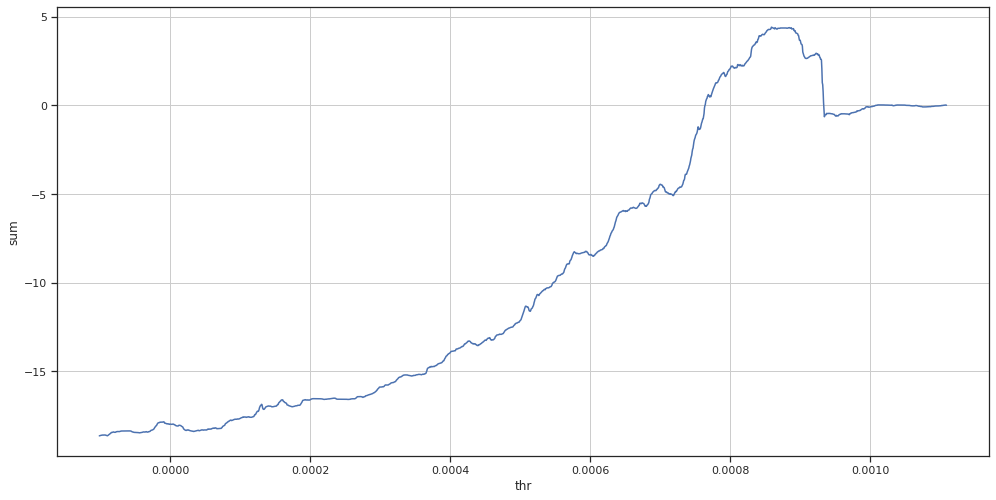

In [8]:
sns.lineplot(x='thr',y='sum',data=results)

<AxesSubplot:xlabel='thr', ylabel='avg'>

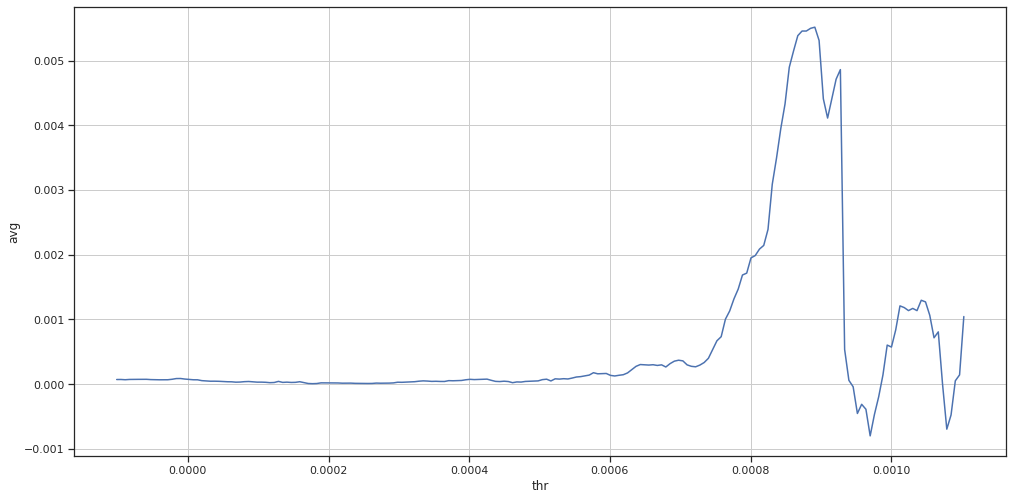

In [227]:
sns.lineplot(x='thr',y='avg',data=results)

In [218]:
print(C[c])
min_n = np.quantile(y_hat_test[:,c],0.001) 
max_n = np.quantile(y_hat_test[:,c],0.999)
results = []
for thr in np.arange(max_n, min_n, -(max_n-min_n)/200):
    results.append({'thr':thr, 'sum':((-y_test[y_hat_test[:,c]<thr, c])-0.001).sum(),'avg':((-y_test[y_hat_test[:,c]<thr, c])-0.001).mean()})
results = pd.DataFrame(results)

BTCUSDT


<AxesSubplot:xlabel='thr', ylabel='sum'>

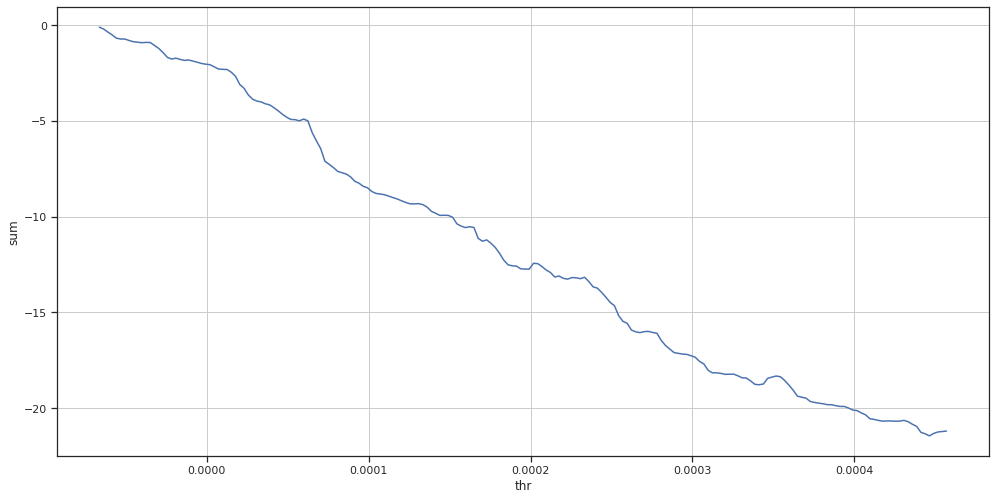

In [219]:
sns.lineplot(x='thr',y='sum',data=results)

<AxesSubplot:xlabel='thr', ylabel='avg'>

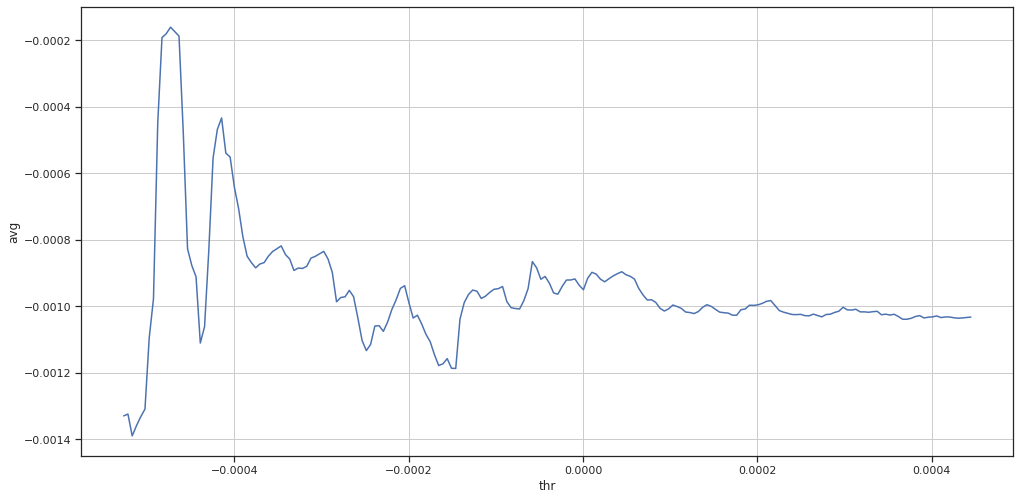

In [213]:
sns.lineplot(x='thr',y='avg',data=results)

In [6]:
# attempt to find better thresholds by looking at predictions of last [sliding window] naive or with LR

In [9]:
from sklearn.linear_model import LinearRegression

predictions = []
for i in tqdm(range(512, y_test.shape[0],1)):
    subsample_hat = y_hat_test[i-512:i-1,:]
    subsample_y = y_test[i-512:i-1,:]
    reg = LinearRegression().fit(subsample_hat, subsample_y)
    predictions.append(reg.predict(y_hat_test[i,:].reshape(1, -1)))

  0%|          | 0/19784 [00:00<?, ?it/s]

In [10]:
predictions_df = np.vstack(predictions)

In [77]:
thresholds = []
for c in range(0,20,1):
    min_n = np.quantile(predictions_df[:,c],0.0001) 
    max_n = np.quantile(predictions_df[:,c],0.9999)
    results = []
    for thr in np.arange(min_n, max_n, (max_n-min_n)/2000):
        results.append({'thr':thr, 'sum':(y_test[512:][predictions_df[:,c]>thr, c]-0.001).sum(),'avg':(y_test[512:][predictions_df[:,c]>thr, c]-0.001).mean()})

    results = pd.DataFrame(results)

    buy_thr = 1
    if results.iloc[results['sum'].argmax()]['sum']>3:
        buy_thr = results.iloc[results['sum'].argmax()+5].thr

    results = []
    for thr in np.arange(min_n, max_n, (max_n-min_n)/2000):
        results.append({'thr':thr, 'sum':(-y_test[512:][predictions_df[:,c]<thr, c]-0.001).sum(),'avg':(-y_test[512:][predictions_df[:,c]<thr, c]-0.001).mean()})

    results = pd.DataFrame(results)

    sell_thr = -1
    if results.iloc[results['sum'].argmax()]['sum']>3:
        sell_thr = results.iloc[results['sum'].argmax()+5].thr

    thresholds.append({'pair':C[c], 'buy_thr': buy_thr, 'sell_thr': sell_thr})

thresholds = pd.DataFrame(thresholds)


In [78]:
thresholds

,pair,buy_thr,sell_thr
0,DOGEUSDT,0.003693,-0.001139
1,AVAXUSDT,0.003184,-0.000901
2,SOLUSDT,0.004011,-0.001114
3,SHIBUSDT,0.002688,-0.000901
4,EURUSDT,1.000000,-1.000000
5,GBPUSDT,1.000000,-1.000000
6,ETCETH,1.000000,-1.000000
7,ETCBTC,1.000000,-1.000000
8,MKRUSDT,0.003294,-0.001232
9,MKRBTC,1.000000,-1.000000


In [79]:
thresholds.to_pickle('thresholds_sum.pkl')

<AxesSubplot:xlabel='thr', ylabel='sum'>

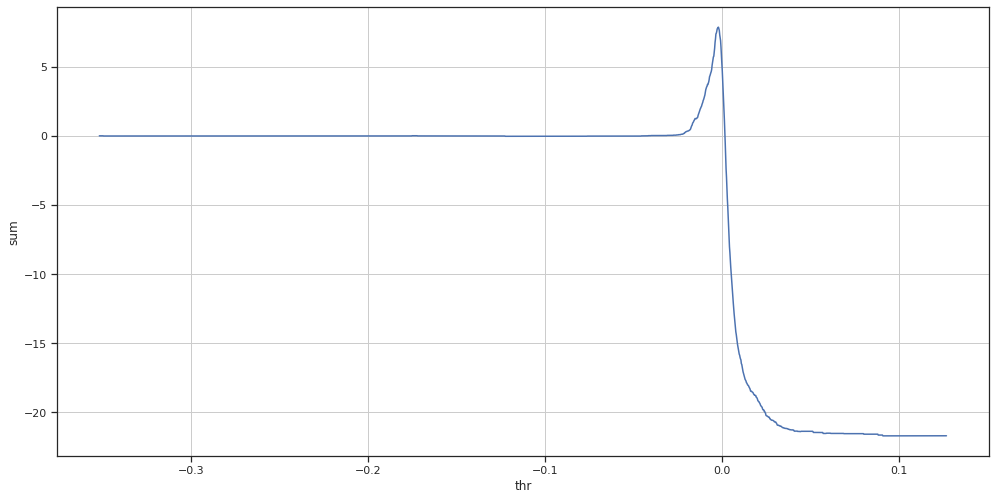

In [48]:
sns.lineplot(x='thr',y='sum',data=results)

thr   -0.002097
sum    7.844540
avg    0.001295
Name: 1461, dtype: float64

0.0007377118

In [56]:
from tqdm.auto import tqdm
trade_results = []
for i in tqdm(range(512, y_test.shape[0],1)):

    subsample = y_test[i-1]
    c = 0

    subsample_hat = y_hat_test[i-512:i-1,c]
    subsample_y = y_test[i-512:i-1,c]

    small = subsample_hat[subsample_y<-0.002]
    med = subsample_hat[(subsample_y>-0.0020) & (subsample_y<0.002)]
    big = subsample_hat[subsample_y>0.002]

    if len(small)>10 and len(big)>10 and small.mean()<big.mean() and scipy.stats.norm(loc=small.mean(), scale=small.std()).cdf(big.mean()) > 0.6:
        if scipy.stats.norm(loc=small.mean(), scale=small.std()).cdf(y_hat_test[i,c]) > 0.65:
            
            p_small = 1-scipy.stats.norm(loc=small.mean(), scale=small.std()).cdf(y_hat_test[i,c])
            p_big = 1-scipy.stats.norm(loc=big.mean(), scale=big.std()).cdf(y_hat_test[i,c])

            if p_big/p_small > 1.5:
                trade_results.append(y_test[i,c])
    
    if len(small)>10 and len(big)>10 and small.mean()>big.mean() and scipy.stats.norm(loc=big.mean(), scale=big.std()).cdf(small.mean()) > 0.6:
        if scipy.stats.norm(loc=small.mean(), scale=small.std()).cdf(y_hat_test[i,c]) > 0.65:
            
            p_small = 1-scipy.stats.norm(loc=small.mean(), scale=small.std()).cdf(y_hat_test[i,c])
            p_big = 1-scipy.stats.norm(loc=big.mean(), scale=big.std()).cdf(y_hat_test[i,c])

            if p_big/p_small > 1.5:
                trade_results.append(y_test[i,c])
        

  0%|          | 0/19784 [00:00<?, ?it/s]

/tmp/ipykernel_19924/3026777023.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  if p_big/p_small > 1.5:


In [59]:
np.array(trade_results).shape

(2838,)

In [60]:
y_test[:,c].shape

(20296,)

In [37]:
big.mean()

0.00073076325

In [43]:
1-scipy.stats.norm(loc=small.mean(), scale=small.std()).cdf(y_hat_test[i,c])

0.08981268537425147

In [42]:
1-scipy.stats.norm(loc=big.mean(), scale=big.std()).cdf(y_hat_test[i,c])

0.15938833579517553

In [41]:
y_hat_test[i,c]

0.0007599592

In [7]:
c = 0
print(C[c])
print(y_hat_test[:,c].sum(), y_test[:,c].sum() )
min_n = np.quantile(y_hat_test[:,c],0.0001) 
max_n = np.quantile(y_hat_test[:,c],0.9999)
results = []
for thr in np.arange(min_n, max_n, (max_n-min_n)/200):
    results.append({'thr':thr, 'sum':(y_test[y_hat_test[:,c]>thr, c]-0.00001).sum(),'avg':(y_test[y_hat_test[:,c]>thr, c]-0.00001).mean()})

DOGEUSDT
11.012492 1.655649


In [7]:
def extract_windows_vectorized(clearing_time_index, max_time, sub_window_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start +
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    
    return sub_windows

In [8]:
idx = extract_windows_vectorized(512,19000,512)

In [102]:
idx.shape

(19001, 512)

In [15]:
from sklearn.linear_model import LinearRegression

predictions = []
for i in tqdm(range(512, y_test.shape[0],1)):
    subsample_hat = y_hat_test[i-512:i-1,:]
    subsample_y = y_test[i-512:i-1,:]
    reg = LinearRegression().fit(subsample_hat, subsample_y)
    predictions.append(reg.predict(y_hat_test[i,:].reshape(1, -1)))

  0%|          | 0/19784 [00:00<?, ?it/s]

In [20]:
y_lr_hat_test = np.vstack(predictions)

In [21]:
y_lr_hat_test.shape

(19784, 20)

In [23]:
y_test.shape

(20296, 20)

In [28]:
y_lr_hat_test

array([[0.00252056, 0.00097179, 0.00263786, ..., 0.00178146, 0.00162601,
        0.0016489 ],
       [0.00266933, 0.00049305, 0.00239992, ..., 0.00229573, 0.0019598 ,
        0.00209546],
       [0.0049963 , 0.00337124, 0.00459099, ..., 0.00421834, 0.00409102,
        0.00402761],
       ...,
       [0.00347418, 0.00329751, 0.00405312, ..., 0.00242865, 0.00278795,
        0.00270128],
       [0.00400786, 0.00426218, 0.00390816, ..., 0.00236285, 0.00287259,
        0.00268018],
       [0.00366169, 0.00417101, 0.00331736, ..., 0.00173485, 0.00217772,
        0.00202894]], dtype=float32)

In [29]:
for i in range(0,20):
    print(i, y_test[512:,i][y_lr_hat_test[:,i]>0].mean(), y_test[512:,i][y_lr_hat_test[:,i]<0].mean())

0 0.001508272 -0.0013156674
1 0.0025820292 -0.0019303084
2 0.00168871 -0.0015524329
3 0.0017912054 -0.001475171
4 4.21819e-05 -3.6878802e-05
5 7.33948e-05 -5.3469004e-05
6 0.00055081974 -0.00052712864
7 0.00049209484 -0.00055053656
8 0.0013814141 -0.001293221
9 0.00073699397 -0.0008016952
10 0.001832245 -0.0015401528
11 0.0015996444 -0.0013154752
12 0.0013509872 -0.0012251325
13 0.0008924437 -0.0009724814
14 0.0014388569 -0.0013046348
15 0.0016695778 -0.0014002449
16 0.0015569655 -0.0013056217
17 0.0009887993 -0.0008748219
18 0.00097329204 -0.0008699196
19 0.0009929519 -0.00086811656


In [13]:
y_test[i,:]

array([ 0.00117648,  0.00078142, -0.00033617,  0.00028634, -0.00088567,
        0.00075698, -0.00325388,  0.00127232, -0.0011825 , -0.00190181,
       -0.0006969 ,  0.00076687, -0.00036228, -0.00110972, -0.0026288 ,
       -0.00153708,  0.00311041,  0.00062823,  0.00061905,  0.00065184],
      dtype=float32)

<AxesSubplot:>

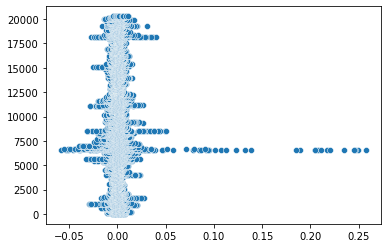

In [35]:
sns.scatterplot(y=y_test[:,0], x=list(range(len(y_test))))

In [103]:
ttest_ind(y_hat_test[y_test[:,4]<0.001,0], y_hat_test[y_test[:,4]>0.001,0])

Ttest_indResult(statistic=-0.2917986766910186, pvalue=0.7704435396582445)

In [9]:
from scipy.stats import ttest_ind
r = []
for i in range(0, 19000,1):
    cl1 = y_hat_test[idx[i],0][y_test[idx[i],0]>0.001]
    cl2 = y_hat_test[idx[i],0][y_test[idx[i],0]<0.001]
    q = ttest_ind(cl1, cl2, alternative='greater')
    r.append(q.pvalue)
    if q.pvalue<0.001: break

In [14]:
idx[i]

array([175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
       279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
       331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 35

In [31]:
y_test[699,0]

-0.00059455633

In [30]:
y_hat_test[699,0]

0.0007594675

In [13]:
y_test[i,0]

0.014084578

In [10]:
cl1.mean()

0.0007192863

In [11]:
cl2.mean()

0.0007095136

In [137]:
cl1.std()

3.5283356e-05

In [145]:
cl1

array([0.00065006, 0.00065048, 0.00065058, 0.00065056, 0.0006496 ,
       0.00064948, 0.00065123, 0.00065202, 0.00065051, 0.00064915,
       0.00064807, 0.00064873, 0.00064801, 0.00064762, 0.00064749,
       0.00064803, 0.00064705, 0.00064757, 0.00064915, 0.00064898,
       0.0006495 , 0.00065146, 0.00065322, 0.00065431, 0.00065401,
       0.00065487, 0.00065526, 0.00065471, 0.00065362, 0.00066067,
       0.0006643 , 0.00067628, 0.00067638, 0.00067648, 0.0006765 ,
       0.00067703, 0.00067776, 0.00067881, 0.00067971, 0.00067941,
       0.00067985, 0.0006799 , 0.0006801 , 0.00067949, 0.00068037,
       0.00068802, 0.00068723, 0.00068779, 0.00071272, 0.0007139 ,
       0.00071354, 0.00071463, 0.0007164 , 0.00071808, 0.00071872,
       0.00071935, 0.00071854, 0.00071886, 0.00071856, 0.00071791,
       0.00071768, 0.00071768, 0.00071766, 0.00071849, 0.00071909,
       0.00071798, 0.00071804, 0.00071839, 0.00071847, 0.00071916,
       0.00071909, 0.00071973, 0.00072011, 0.00071916, 0.00071

In [167]:
import scipy


0.3908984590605237

In [169]:
scipy.stats.norm(loc=cl2.mean(), scale=cl2.std()).sf(cl2.mean()+0.00003)

0.18861646946145416

In [93]:
y_test[y_hat_test[:,c]>0.00001,c].sum()

1.494077

In [96]:
y_test[y_hat_test[:,c]<-0.001,c].sum()

0.0

In [30]:
final_data = pd.read_pickle('final_data.pkl')

In [59]:
def extract_windows_vectorized(clearing_time_index, max_time, sub_window_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    
    sub_windows = (
        start +
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    
    return sub_windows
import yaml

with open("config.yaml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

In [56]:
extract_windows_vectorized(512, 1000-512-16, 512)

array([[  2,   3,   4, ..., 511, 512, 513],
       [  3,   4,   5, ..., 512, 513, 514],
       [  4,   5,   6, ..., 513, 514, 515],
       ...,
       [472, 473, 474, ..., 981, 982, 983],
       [473, 474, 475, ..., 982, 983, 984],
       [474, 475, 476, ..., 983, 984, 985]])

In [79]:
idx = extract_windows_vectorized(512, 1000-512-17, 512)

In [80]:
idx

array([[  2,   3,   4, ..., 511, 512, 513],
       [  3,   4,   5, ..., 512, 513, 514],
       [  4,   5,   6, ..., 513, 514, 515],
       ...,
       [471, 472, 473, ..., 980, 981, 982],
       [472, 473, 474, ..., 981, 982, 983],
       [473, 474, 475, ..., 982, 983, 984]])

In [78]:
final_data.iloc[999]

open_DOGEUSDT                           0.650828
high_DOGEUSDT                           0.648422
low_DOGEUSDT                            0.651940
close_DOGEUSDT                          0.650821
volume_DOGEUSDT                        -0.202367
                                          ...   
volume_BTCUSDT                         -0.619445
quote_asset_volume_BTCUSDT             -0.504206
number_of_trades_BTCUSDT               -0.577671
taker_buy_base_asset_volume_BTCUSDT    -0.599122
taker_buy_quote_asset_volume_BTCUSDT   -0.505320
Name: 999, Length: 180, dtype: float32

In [81]:
+15

array([528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
       541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553,
       554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566,
       567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579,
       580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592,
       593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605,
       606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618,
       619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631,
       632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657,
       658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670,
       671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683,
       684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696,
       697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 70

In [58]:
final_data.values[idx]..shape

(487, 512, 180)

In [55]:
final_data.values[idx].shape

(487, 512, 180)

In [82]:
final_data[['close_'+x for x in cfg['models']['resnet']['symbols']]].iloc[idx[:,-1]]

,close_DOGEUSDT,close_AVAXUSDT,close_SOLUSDT,close_SHIBUSDT,close_EURUSDT,close_GBPUSDT,close_ETCETH,close_ETCBTC,close_MKRUSDT,close_MKRBTC,close_IOTAUSDT,close_ADAUSDT,close_XLMUSDT,close_TRXUSDT,close_XMRUSDT,close_EOSUSDT,close_DOGEGBP,close_BTCEUR,close_BTCGBP,close_BTCUSDT
513,0.658972,2.711890,1.992090,1.034568,-0.545294,-0.374677,-0.927297,-0.074611,0.533072,-0.041066,1.167096,0.929188,0.474671,0.855213,0.688077,-0.218173,-0.257058,1.227304,0.946174,1.126792
514,0.659713,2.716069,1.994153,1.035691,-0.545294,-0.396890,-0.927297,-0.070078,0.535471,-0.041066,1.169185,0.933993,0.477780,0.855213,0.689116,-0.215487,-0.255852,1.228411,0.947360,1.128104
515,0.658972,2.713498,1.994566,1.035129,-0.545294,-0.396890,-0.927297,-0.070078,0.537870,-0.031666,1.169881,0.933993,0.477780,0.856305,0.688077,-0.217501,-0.255852,1.229234,0.947393,1.128508
516,0.660454,2.713176,1.994566,1.034006,-0.545294,-0.396890,-0.927297,-0.067811,0.540269,-0.033755,1.168837,0.933993,0.480266,0.857669,0.679763,-0.217501,-0.255852,1.229926,0.947905,1.129309
517,0.660454,2.714462,1.996354,1.032322,-0.545294,-0.396890,-0.927297,-0.072344,0.540269,-0.031143,1.170578,0.933993,0.481510,0.857669,0.679763,-0.215487,-0.255852,1.230770,0.948672,1.129984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,0.644892,2.696461,1.969120,1.058713,-0.522660,-0.330247,-0.934001,-0.083678,0.517078,-0.053078,1.177890,0.906363,0.503272,0.870226,0.660016,-0.222873,-0.277570,1.218588,0.929876,1.122110
981,0.644892,2.697104,1.964718,1.059837,-0.545294,-0.330247,-0.934001,-0.083678,0.517878,-0.053078,1.175801,0.906363,0.503272,0.869953,0.658977,-0.223545,-0.275157,1.218701,0.932631,1.121537
982,0.646374,2.695818,1.966231,1.060398,-0.545294,-0.330247,-0.933163,-0.083678,0.517878,-0.053078,1.177716,0.907565,0.505137,0.870772,0.660016,-0.222873,-0.275157,1.219651,0.932644,1.122849
983,0.647115,2.698069,1.965131,1.058713,-0.522660,-0.308031,-0.933163,-0.083678,0.517878,-0.055689,1.176671,0.908766,0.505759,0.871591,0.660016,-0.222202,-0.275157,1.220246,0.934519,1.123383


In [94]:
prev_price = final_data[['close_'+x for x in cfg['models']['resnet']['symbols']]].iloc[idx[:,-1]]
cur_price = final_data[['close_'+x for x in cfg['models']['resnet']['symbols']]].iloc[idx[:,-1]+15]

In [99]:
((cur_price.values / prev_price.values) - 1).shape

(472, 20)

In [102]:
final_data.values[idx].swapaxes(1, 2).astype(np.float32).shape

(472, 180, 512)

In [96]:
cur_price

,close_DOGEUSDT,close_AVAXUSDT,close_SOLUSDT,close_SHIBUSDT,close_EURUSDT,close_GBPUSDT,close_ETCETH,close_ETCBTC,close_MKRUSDT,close_MKRBTC,close_IOTAUSDT,close_ADAUSDT,close_XLMUSDT,close_TRXUSDT,close_XMRUSDT,close_EOSUSDT,close_DOGEGBP,close_BTCEUR,close_BTCGBP,close_BTCUSDT
528,0.654526,2.698069,1.988927,1.034006,-0.567929,-0.396890,-0.925620,-0.067811,0.533871,-0.033232,1.160132,0.924383,0.476536,0.855759,0.677684,-0.222202,-0.259471,1.222070,0.939613,1.121841
529,0.655267,2.699354,1.990577,1.036814,-0.567929,-0.374677,-0.925620,-0.067811,0.534671,-0.032188,1.161002,0.929188,0.476536,0.856032,0.678724,-0.220187,-0.260678,1.224053,0.941042,1.123159
530,0.656008,2.704176,1.992228,1.039060,-0.567929,-0.374677,-0.925620,-0.067811,0.536270,-0.032188,1.163440,0.929188,0.477158,0.857123,0.678724,-0.220859,-0.258265,1.225915,0.940673,1.125326
531,0.656008,2.703212,1.991128,1.035691,-0.567929,-0.352460,-0.926459,-0.070078,0.537070,-0.030621,1.164658,0.929188,0.477158,0.857397,0.692234,-0.221530,-0.258265,1.224341,0.940531,1.124042
532,0.656749,2.700640,1.990990,1.035129,-0.545294,-0.374677,-0.925620,-0.067811,0.536270,-0.030621,1.162047,0.929188,0.478401,0.857397,0.695352,-0.220859,-0.258265,1.224774,0.942032,1.123704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.651562,2.716391,1.976135,1.069944,-0.545294,-0.308031,-0.933163,-0.081411,0.522676,-0.060390,1.184157,0.912370,0.511977,0.876778,0.662095,-0.214144,-0.270331,1.230429,0.944071,1.132874
996,0.650079,2.720248,1.971321,1.071067,-0.545294,-0.330247,-0.931487,-0.081411,0.521876,-0.060390,1.186595,0.909967,0.509490,0.875140,0.662095,-0.216830,-0.270331,1.229380,0.944071,1.131846
997,0.650079,2.724105,1.974071,1.071067,-0.545294,-0.308031,-0.931487,-0.081411,0.520277,-0.064046,1.187465,0.909967,0.510733,0.875686,0.663134,-0.215487,-0.270331,1.232048,0.946684,1.133937
998,0.650821,2.725391,1.976410,1.072190,-0.545294,-0.330247,-0.932325,-0.081411,0.522676,-0.064046,1.187987,0.909967,0.512599,0.875686,0.660016,-0.214144,-0.270331,1.232196,0.945869,1.134475


In [97]:
prev_price

,close_DOGEUSDT,close_AVAXUSDT,close_SOLUSDT,close_SHIBUSDT,close_EURUSDT,close_GBPUSDT,close_ETCETH,close_ETCBTC,close_MKRUSDT,close_MKRBTC,close_IOTAUSDT,close_ADAUSDT,close_XLMUSDT,close_TRXUSDT,close_XMRUSDT,close_EOSUSDT,close_DOGEGBP,close_BTCEUR,close_BTCGBP,close_BTCUSDT
513,0.658972,2.711890,1.992090,1.034568,-0.545294,-0.374677,-0.927297,-0.074611,0.533072,-0.041066,1.167096,0.929188,0.474671,0.855213,0.688077,-0.218173,-0.257058,1.227304,0.946174,1.126792
514,0.659713,2.716069,1.994153,1.035691,-0.545294,-0.396890,-0.927297,-0.070078,0.535471,-0.041066,1.169185,0.933993,0.477780,0.855213,0.689116,-0.215487,-0.255852,1.228411,0.947360,1.128104
515,0.658972,2.713498,1.994566,1.035129,-0.545294,-0.396890,-0.927297,-0.070078,0.537870,-0.031666,1.169881,0.933993,0.477780,0.856305,0.688077,-0.217501,-0.255852,1.229234,0.947393,1.128508
516,0.660454,2.713176,1.994566,1.034006,-0.545294,-0.396890,-0.927297,-0.067811,0.540269,-0.033755,1.168837,0.933993,0.480266,0.857669,0.679763,-0.217501,-0.255852,1.229926,0.947905,1.129309
517,0.660454,2.714462,1.996354,1.032322,-0.545294,-0.396890,-0.927297,-0.072344,0.540269,-0.031143,1.170578,0.933993,0.481510,0.857669,0.679763,-0.215487,-0.255852,1.230770,0.948672,1.129984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,0.644892,2.696461,1.969120,1.058713,-0.522660,-0.330247,-0.934001,-0.083678,0.517078,-0.053078,1.177890,0.906363,0.503272,0.870226,0.660016,-0.222873,-0.277570,1.218588,0.929876,1.122110
981,0.644892,2.697104,1.964718,1.059837,-0.545294,-0.330247,-0.934001,-0.083678,0.517878,-0.053078,1.175801,0.906363,0.503272,0.869953,0.658977,-0.223545,-0.275157,1.218701,0.932631,1.121537
982,0.646374,2.695818,1.966231,1.060398,-0.545294,-0.330247,-0.933163,-0.083678,0.517878,-0.053078,1.177716,0.907565,0.505137,0.870772,0.660016,-0.222873,-0.275157,1.219651,0.932644,1.122849
983,0.647115,2.698069,1.965131,1.058713,-0.522660,-0.308031,-0.933163,-0.083678,0.517878,-0.055689,1.176671,0.908766,0.505759,0.871591,0.660016,-0.222202,-0.275157,1.220246,0.934519,1.123383


In [98]:
0.654526 / 0.658972

0.9932531275987447

In [103]:
idx = extract_windows_vectorized(512, 1000 - 512 - 17, 512)

In [104]:
idx

array([[  2,   3,   4, ..., 511, 512, 513],
       [  3,   4,   5, ..., 512, 513, 514],
       [  4,   5,   6, ..., 513, 514, 515],
       ...,
       [471, 472, 473, ..., 980, 981, 982],
       [472, 473, 474, ..., 981, 982, 983],
       [473, 474, 475, ..., 982, 983, 984]])

In [106]:
column_names = ["close_" + x for x in cfg["models"]["resnet"]["symbols"]]
prev_price = final_data[column_names].iloc[idx[:, -1]]

In [107]:
prev_price

,close_DOGEUSDT,close_AVAXUSDT,close_SOLUSDT,close_SHIBUSDT,close_EURUSDT,close_GBPUSDT,close_ETCETH,close_ETCBTC,close_MKRUSDT,close_MKRBTC,close_IOTAUSDT,close_ADAUSDT,close_XLMUSDT,close_TRXUSDT,close_XMRUSDT,close_EOSUSDT,close_DOGEGBP,close_BTCEUR,close_BTCGBP,close_BTCUSDT
513,0.658972,2.711890,1.992090,1.034568,-0.545294,-0.374677,-0.927297,-0.074611,0.533072,-0.041066,1.167096,0.929188,0.474671,0.855213,0.688077,-0.218173,-0.257058,1.227304,0.946174,1.126792
514,0.659713,2.716069,1.994153,1.035691,-0.545294,-0.396890,-0.927297,-0.070078,0.535471,-0.041066,1.169185,0.933993,0.477780,0.855213,0.689116,-0.215487,-0.255852,1.228411,0.947360,1.128104
515,0.658972,2.713498,1.994566,1.035129,-0.545294,-0.396890,-0.927297,-0.070078,0.537870,-0.031666,1.169881,0.933993,0.477780,0.856305,0.688077,-0.217501,-0.255852,1.229234,0.947393,1.128508
516,0.660454,2.713176,1.994566,1.034006,-0.545294,-0.396890,-0.927297,-0.067811,0.540269,-0.033755,1.168837,0.933993,0.480266,0.857669,0.679763,-0.217501,-0.255852,1.229926,0.947905,1.129309
517,0.660454,2.714462,1.996354,1.032322,-0.545294,-0.396890,-0.927297,-0.072344,0.540269,-0.031143,1.170578,0.933993,0.481510,0.857669,0.679763,-0.215487,-0.255852,1.230770,0.948672,1.129984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,0.644892,2.696461,1.969120,1.058713,-0.522660,-0.330247,-0.934001,-0.083678,0.517078,-0.053078,1.177890,0.906363,0.503272,0.870226,0.660016,-0.222873,-0.277570,1.218588,0.929876,1.122110
981,0.644892,2.697104,1.964718,1.059837,-0.545294,-0.330247,-0.934001,-0.083678,0.517878,-0.053078,1.175801,0.906363,0.503272,0.869953,0.658977,-0.223545,-0.275157,1.218701,0.932631,1.121537
982,0.646374,2.695818,1.966231,1.060398,-0.545294,-0.330247,-0.933163,-0.083678,0.517878,-0.053078,1.177716,0.907565,0.505137,0.870772,0.660016,-0.222873,-0.275157,1.219651,0.932644,1.122849
983,0.647115,2.698069,1.965131,1.058713,-0.522660,-0.308031,-0.933163,-0.083678,0.517878,-0.055689,1.176671,0.908766,0.505759,0.871591,0.660016,-0.222202,-0.275157,1.220246,0.934519,1.123383


In [108]:
cur_price = final_data[column_names].iloc[idx[:, -1] + 15]

In [109]:
cur_price

,close_DOGEUSDT,close_AVAXUSDT,close_SOLUSDT,close_SHIBUSDT,close_EURUSDT,close_GBPUSDT,close_ETCETH,close_ETCBTC,close_MKRUSDT,close_MKRBTC,close_IOTAUSDT,close_ADAUSDT,close_XLMUSDT,close_TRXUSDT,close_XMRUSDT,close_EOSUSDT,close_DOGEGBP,close_BTCEUR,close_BTCGBP,close_BTCUSDT
528,0.654526,2.698069,1.988927,1.034006,-0.567929,-0.396890,-0.925620,-0.067811,0.533871,-0.033232,1.160132,0.924383,0.476536,0.855759,0.677684,-0.222202,-0.259471,1.222070,0.939613,1.121841
529,0.655267,2.699354,1.990577,1.036814,-0.567929,-0.374677,-0.925620,-0.067811,0.534671,-0.032188,1.161002,0.929188,0.476536,0.856032,0.678724,-0.220187,-0.260678,1.224053,0.941042,1.123159
530,0.656008,2.704176,1.992228,1.039060,-0.567929,-0.374677,-0.925620,-0.067811,0.536270,-0.032188,1.163440,0.929188,0.477158,0.857123,0.678724,-0.220859,-0.258265,1.225915,0.940673,1.125326
531,0.656008,2.703212,1.991128,1.035691,-0.567929,-0.352460,-0.926459,-0.070078,0.537070,-0.030621,1.164658,0.929188,0.477158,0.857397,0.692234,-0.221530,-0.258265,1.224341,0.940531,1.124042
532,0.656749,2.700640,1.990990,1.035129,-0.545294,-0.374677,-0.925620,-0.067811,0.536270,-0.030621,1.162047,0.929188,0.478401,0.857397,0.695352,-0.220859,-0.258265,1.224774,0.942032,1.123704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.651562,2.716391,1.976135,1.069944,-0.545294,-0.308031,-0.933163,-0.081411,0.522676,-0.060390,1.184157,0.912370,0.511977,0.876778,0.662095,-0.214144,-0.270331,1.230429,0.944071,1.132874
996,0.650079,2.720248,1.971321,1.071067,-0.545294,-0.330247,-0.931487,-0.081411,0.521876,-0.060390,1.186595,0.909967,0.509490,0.875140,0.662095,-0.216830,-0.270331,1.229380,0.944071,1.131846
997,0.650079,2.724105,1.974071,1.071067,-0.545294,-0.308031,-0.931487,-0.081411,0.520277,-0.064046,1.187465,0.909967,0.510733,0.875686,0.663134,-0.215487,-0.270331,1.232048,0.946684,1.133937
998,0.650821,2.725391,1.976410,1.072190,-0.545294,-0.330247,-0.932325,-0.081411,0.522676,-0.064046,1.187987,0.909967,0.512599,0.875686,0.660016,-0.214144,-0.270331,1.232196,0.945869,1.134475
